In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.applications as zoo
import tensorflow.keras.layers as L
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score

In [2]:
!unzip -q ../input/dogs-vs-cats/train.zip -d . 
!unzip -q ../input/dogs-vs-cats/test1.zip -d . 

In [3]:
filenames = os.listdir("./train")
categories = []
for filename in filenames:
    categories.append(filename.split('.')[0])

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
train_df, val_test_df = train_test_split(df, test_size=7000, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

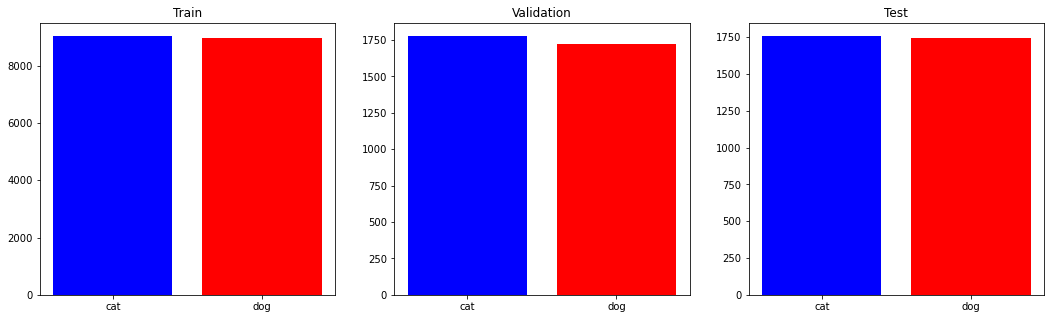

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].bar(['cat', 'dog'], train_df.category.value_counts(), color=['b', 'r'])
ax[0].set_title('Train')
ax[1].bar(['cat', 'dog'], val_df.category.value_counts(), color=['b', 'r'])
ax[1].set_title('Validation')
ax[2].bar(['cat', 'dog'], test_df.category.value_counts(), color=['b', 'r'])
ax[2].set_title('Test')
plt.show()

In [10]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
EARLY_STOP_PATIENCE = 7

In [11]:
data_generator = ImageDataGenerator(
    rescale=1./255
)

train = data_generator.flow_from_dataframe(
    train_df, 
    "./train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val = data_generator.flow_from_dataframe(
    val_df, 
    "./train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

test = data_generator.flow_from_dataframe(
    test_df, 
    "./train", 
    x_col='filename',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

Found 18000 validated image filenames belonging to 2 classes.
Found 3500 validated image filenames belonging to 2 classes.
Found 3500 validated image filenames.


In [12]:
base = zoo.VGG16(include_top=False, input_shape=IMAGE_SIZE +(3,))
base.trainable = False
base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [13]:
model = tf.keras.Sequential()
model.add(base)
model.add(L.GlobalAveragePooling2D())
model.add(L.Flatten())
model.add(L.BatchNormalization())
model.add(L.ReLU())
model.add(L.Dense(256))
model.add(L.Dropout(0.3))
model.add(L.BatchNormalization())
model.add(L.ReLU())
model.add(L.Dropout(0.3))
model.add(L.Dense(2))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [14]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=opt, metrics=['acc'])
early_stop = EarlyStopping(
    monitor='val_acc',
    patience=EARLY_STOP_PATIENCE, 
    restore_best_weights=True
)
checkpoint = ModelCheckpoint(
    filepath='./vgg16_best.hdf5',
    monitor='acc',
    save_best_only=True,
    mode='auto'
)
checkpoint_val = ModelCheckpoint(
    filepath = './vgg16_best_val.hdf5',
    save_best_only = True,
    mode = 'auto'
)

In [15]:
history1 = model.fit(
    train, 
    validation_data=val,
    batch_size=BATCH_SIZE,
    epochs=35,
    callbacks=[early_stop, checkpoint, checkpoint_val]
)

Epoch 1/35
563/563 [==============================] - 91s 154ms/step - loss: 0.3555 - acc: 0.8437 - val_loss: 0.2051 - val_acc: 0.9171
Epoch 2/35
563/563 [==============================] - 83s 147ms/step - loss: 0.2157 - acc: 0.9113 - val_loss: 0.1856 - val_acc: 0.9220
Epoch 3/35
563/563 [==============================] - 88s 157ms/step - loss: 0.1980 - acc: 0.9156 - val_loss: 0.1796 - val_acc: 0.9269
Epoch 4/35
563/563 [==============================] - 86s 153ms/step - loss: 0.1824 - acc: 0.9219 - val_loss: 0.1715 - val_acc: 0.9303
Epoch 5/35
563/563 [==============================] - 85s 152ms/step - loss: 0.1794 - acc: 0.9228 - val_loss: 0.1695 - val_acc: 0.9340
Epoch 6/35
563/563 [==============================] - 85s 152ms/step - loss: 0.1645 - acc: 0.9312 - val_loss: 0.1712 - val_acc: 0.9306
Epoch 7/35
563/563 [==============================] - 85s 152ms/step - loss: 0.1674 - acc: 0.9284 - val_loss: 0.1654 - val_acc: 0.9320
Epoch 8/35
563/563 [==============================] - 8

In [16]:
base.trainable = False
history2 = model.fit(
    train, 
    validation_data=val,
    batch_size=BATCH_SIZE,
    epochs=25,
    callbacks=[early_stop, checkpoint, checkpoint_val]
)

Epoch 1/25
563/563 [==============================] - 80s 142ms/step - loss: 0.1148 - acc: 0.9534 - val_loss: 0.1718 - val_acc: 0.9360
Epoch 2/25
563/563 [==============================] - 79s 141ms/step - loss: 0.1205 - acc: 0.9516 - val_loss: 0.1765 - val_acc: 0.9297
Epoch 3/25
563/563 [==============================] - 80s 141ms/step - loss: 0.1140 - acc: 0.9528 - val_loss: 0.1729 - val_acc: 0.9314
Epoch 4/25
563/563 [==============================] - 79s 141ms/step - loss: 0.1065 - acc: 0.9566 - val_loss: 0.1785 - val_acc: 0.9323
Epoch 5/25
563/563 [==============================] - 81s 143ms/step - loss: 0.1007 - acc: 0.9588 - val_loss: 0.1671 - val_acc: 0.9380
Epoch 6/25
563/563 [==============================] - 80s 143ms/step - loss: 0.0989 - acc: 0.9601 - val_loss: 0.1721 - val_acc: 0.9351
Epoch 7/25
563/563 [==============================] - 79s 140ms/step - loss: 0.1025 - acc: 0.9588 - val_loss: 0.1742 - val_acc: 0.9351
Epoch 8/25
563/563 [==============================] - 8

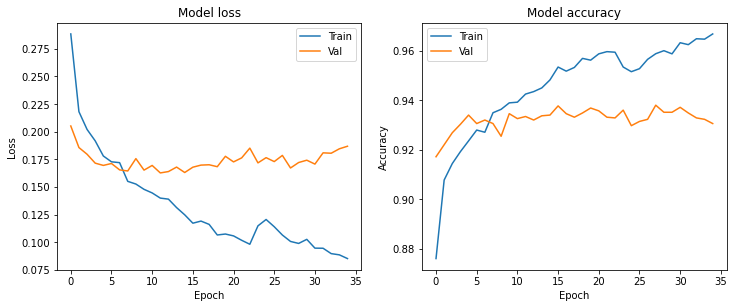

In [21]:
train_loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']
train_acc = history1.history['acc'] + history2.history['acc']
val_acc = history1.history['val_acc'] + history2.history['val_acc']

plt.figure(figsize=(12, 10))
plt.subplot(221)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])

plt.subplot(222)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.show()

In [32]:
model.load_weights('./vgg16_best_val.hdf5')
pred = model.predict(test)
pred = tf.nn.softmax(pred, axis=-1).numpy()
pred = np.argmax(pred, axis=-1)
accuracy_score(test_df['category'] == 'dog', pred)

0.9214285714285714

In [51]:
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32
EARLY_STOP_PATIENCE = 7

In [52]:
data_generator = ImageDataGenerator(
    rescale=1./255
)

train = data_generator.flow_from_dataframe(
    train_df, 
    "./train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val = data_generator.flow_from_dataframe(
    val_df, 
    "./train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

test = data_generator.flow_from_dataframe(
    test_df, 
    "./train", 
    x_col='filename',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

Found 18000 validated image filenames belonging to 2 classes.
Found 3500 validated image filenames belonging to 2 classes.
Found 3500 validated image filenames.


In [53]:
base = zoo.InceptionV3(include_top=False, input_shape=IMAGE_SIZE +(3,))
base.trainable = False
base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_384 (BatchN (None, 149, 149, 32) 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 149, 149, 32) 0           batch_normalization_384[0][0]    
_______________________________________________________________________________________

In [54]:
model = tf.keras.Sequential()
model.add(base)
model.add(L.GlobalAveragePooling2D())
model.add(L.Flatten())
model.add(L.BatchNormalization())
model.add(L.ReLU())
model.add(L.Dense(512))
model.add(L.Dropout(0.5))
model.add(L.BatchNormalization())
model.add(L.ReLU())
model.add(L.Dropout(0.5))
model.add(L.Dense(2))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_478 (Bat (None, 2048)              8192      
_________________________________________________________________
re_lu_8 (ReLU)               (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)              

In [55]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=opt, metrics=['acc'])
early_stop = EarlyStopping(
    monitor='val_acc',
    patience=EARLY_STOP_PATIENCE, 
    restore_best_weights=True
)
checkpoint = ModelCheckpoint(
    filepath='./incV3_best.hdf5',
    monitor='acc',
    save_best_only=True,
    mode='auto'
)
checkpoint_val = ModelCheckpoint(
    filepath = './incV3_best_val.hdf5',
    save_best_only = True,
    mode = 'auto'
)

In [56]:
history1 = model.fit(
    train, 
    validation_data=val,
    batch_size=BATCH_SIZE,
    epochs=10,
    callbacks=[early_stop, checkpoint, checkpoint_val]
)

Epoch 1/10
563/563 [==============================] - 118s 202ms/step - loss: 0.0629 - acc: 0.9798 - val_loss: 0.0363 - val_acc: 0.9883
Epoch 2/10
563/563 [==============================] - 113s 200ms/step - loss: 0.0323 - acc: 0.9902 - val_loss: 0.0263 - val_acc: 0.9914
Epoch 3/10
563/563 [==============================] - 112s 199ms/step - loss: 0.0210 - acc: 0.9928 - val_loss: 0.0257 - val_acc: 0.9909
Epoch 4/10
563/563 [==============================] - 112s 199ms/step - loss: 0.0214 - acc: 0.9926 - val_loss: 0.0277 - val_acc: 0.9906
Epoch 5/10
563/563 [==============================] - 112s 199ms/step - loss: 0.0204 - acc: 0.9928 - val_loss: 0.0289 - val_acc: 0.9909
Epoch 6/10
563/563 [==============================] - 112s 200ms/step - loss: 0.0195 - acc: 0.9951 - val_loss: 0.0317 - val_acc: 0.9886
Epoch 7/10
563/563 [==============================] - 112s 199ms/step - loss: 0.0179 - acc: 0.9945 - val_loss: 0.0321 - val_acc: 0.9886
Epoch 8/10
563/563 [============================

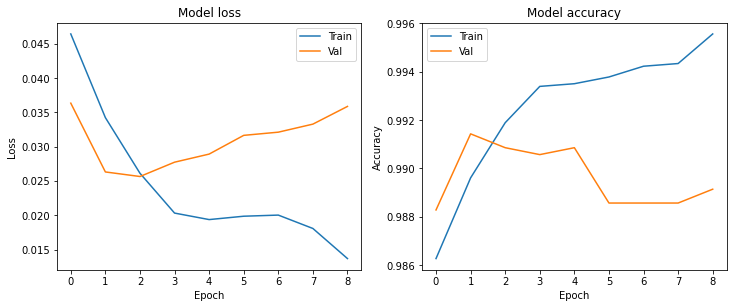

In [57]:
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
train_acc = history1.history['acc']
val_acc = history1.history['val_acc']

plt.figure(figsize=(12, 10))
plt.subplot(221)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])

plt.subplot(222)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.show()

In [58]:
model.load_weights('./incV3_best_val.hdf5')
pred = model.predict(test)
pred = tf.nn.softmax(pred, axis=-1).numpy()
pred = np.argmax(pred, axis=-1)
accuracy_score(test_df['category'] == 'dog', pred)

0.9894285714285714